# Toy hierarchical model

In [38]:
import jax
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd

from coinem.model import AbstractModel
from coinem.dataset import Dataset

## Model

We consider generating data $y$ from a hierarchical Gaussian model with real-valued hyperparameter $\theta = 1$:

$$ p_\theta(x, y) = \mathcal{N}(y; x, I_{D_y}) \mathcal{N}(x; \theta I_{D_y}, I_{D_y}) $$

### Model in code:
To create our model we just inherit from the provided `AbstractModel`.

In [39]:
from jaxtyping import Array, Float, PyTree


@dataclass
class HierarchicalModel(AbstractModel):
    """Base class for p(θ, x)."""
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        log_prob_y_given_x = tfd.MultivariateNormalDiag(jnp.atleast_1d(latent.squeeze())).log_prob(jnp.atleast_1d(data.y.squeeze())).sum() # \mathcal{N}(y; x, I_{D_y}) 
        log_prob_x_given_theta = tfd.Normal(theta, scale=1.0).log_prob(jnp.atleast_1d(latent.squeeze())).sum() # \mathcal{N}(x; \theta I_{D_y}, I_{D_y})

        # Compute log-probability.
        return (log_prob_y_given_x + log_prob_x_given_theta).squeeze() # log p(y|x) + log p(x|theta)
    
    def optimal_theta(self, latent_particles: PyTree[Float[Array, "N D *"]]) -> PyTree[Float[Array, "Q *"]]:
        return latent_particles.mean().reshape(-1) # WARNING: This assumes a single dimension for the "x"!

### Dataset:
We draw one observation $y$ from the model.

In [40]:
Ny = 1
Dy = 100
key = jr.PRNGKey(42)
theta = jnp.array([1.0])

key_y, key_latent = jr.split(key)
latent = theta + jr.normal(key_latent, (1, Dy))
y = jr.normal(key_y, (Ny, Dy)) + latent

### Unit tests:
We test the score of the latent function and average log-probability of the model.

In [41]:
# Define the model:
model = HierarchicalModel()
data = Dataset(y=y)

# Unit tests:
assert jnp.allclose(model.score_latent(latent, theta, data), (y + theta - 2.0* latent)) # Gradient of log p(y|x) wrt x
assert jnp.allclose(model.score_theta(latent, theta, data), Dy * (latent.mean() - theta)) # Gradient of log p(y|x) wrt theta

### EM algorithm

For this example we can find the EM algorithm in closed form, for the theta updates given below.

In [42]:
def em(model, data, theta, K):
    """Expectation Maximization Algorithm. Returns parameter estimates."""

    def em_step(theta, k):
        new_theta = theta/2.0 + data.y.mean()/2.0
        return new_theta, theta

    _, thetas = jax.lax.scan(em_step, theta, jnp.arange(K))

    return thetas

# Experiment 1 (Step size comparison)

We illustrate the impact of different step-sizes:

In [43]:
from coinem.zoo import coin_svgd, ada_svgd, soul, pgd
from coinem.marginal_zoo import marginal_coin_svgd, marginal_ada_svgd, marginal_soul, marginal_pgd

key = jr.PRNGKey(42)
K = 100  # Number of steps.
N = 50  # Number of particles.

th0 = jnp.array([0.0])  # Initial parameter guess.
X0 = jr.normal(key, (N, Dy))  # Initial particle cloud.  -NOTE: I've changed this from np.zeros because the X's in SVGD have to be different for the kernel computation

model = HierarchicalModel()

# Run EM:
th_em = em(model, data, th0, K)
x_mean_em = (data.y.squeeze()  + th_em) /2 

# Run coin_svgd:
x_coin, th_coin = coin_svgd(model, data, X0, th0, K)  # coin_svgd

# Run marginal_coin_svgd:
x_marginal_coin, th_marginal_coin = marginal_coin_svgd(model, data, X0, th0, K)  # marginal_coin_svgd

# Run PGD using three different step-sizes:
large = 2.05/(2+Dy)
optimal = 2/(2+Dy)
small = 0.75/(2+Dy)

x_large, th_large = pgd(model, data, X0, th0, K, latent_step_size=large, theta_step_size=large)  # Large step-size
x_optimal, th_optimal = pgd(model, data, X0, th0, K, latent_step_size=optimal, theta_step_size=optimal)  # Optimal step-size
x_small, th_small = pgd(model, data, X0, th0, K, latent_step_size=small, theta_step_size=small)  # Small step-size

# # Run Adam-SVGD using theree different step-sizes:
large = 2e-1
good = 2e-2
small = 2e-3

x_adam_large, th_adam_large = ada_svgd(model, data, X0, th0, K, theta_step_size = large, latent_step_size= large)  # Large step-size
x_adam_good, th_adam_good = ada_svgd(model, data, X0, th0, K, theta_step_size = good, latent_step_size= good)  # Good step-size
x_adam_small, th_adam_small = ada_svgd(model, data, X0, th0, K, theta_step_size = small, latent_step_size= small)  # Small step-size


# # Run soul using theree different step-sizes:
large = 1e-2
good = 3e-3
small = 2e-3

x_soul_large, th_soul_large = soul(model, data, X0, th0, K, theta_step_size = large, latent_step_size= large)  # Large step-size
x_soul_good, th_soul_good = soul(model, data, X0, th0, K, theta_step_size = good, latent_step_size= good)  # Good step-size
x_soul_small, th_soul_small = soul(model, data, X0, th0, K, theta_step_size = small, latent_step_size= small)  # Small step-size

# Figure 1

### (a) PGD vs Coin

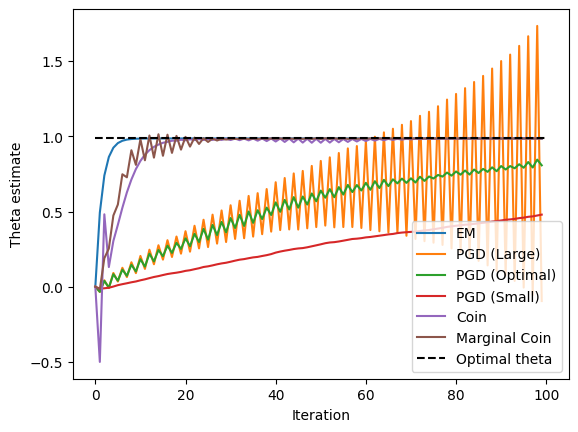

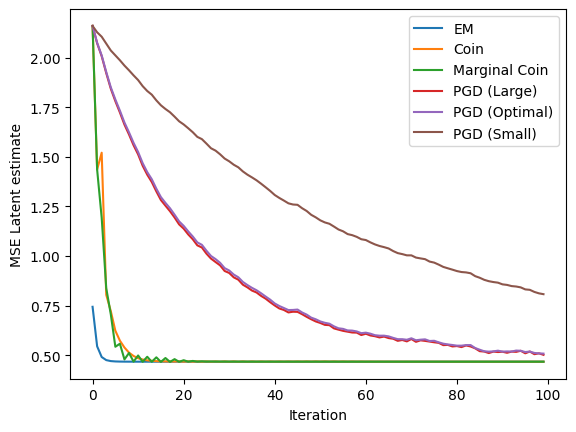

In [44]:
# Plot parameter estimates as a function of step number k:
plt.plot(th_em, label='EM')
plt.plot(th_large, label='PGD (Large)')
plt.plot(th_optimal, label='PGD (Optimal)')
plt.plot(th_small, label='PGD (Small)')
plt.plot(th_coin, label='Coin')
plt.plot(th_marginal_coin, label='Marginal Coin')
plt.hlines(y.mean(), 0, K, label='Optimal theta', linestyles='dashed', color='black')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.ylabel("Theta estimate")
plt.show()

plt.plot(((x_mean_em - latent) ** 2).mean(axis=1), label='EM')
plt.plot(((x_coin.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin')
plt.plot(((x_marginal_coin.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Marginal Coin')
plt.plot(((x_large.mean(axis=1) - latent) ** 2).mean(axis = 1), label='PGD (Large)')
plt.plot(((x_optimal.mean(axis=1) - latent) ** 2).mean(axis = 1), label='PGD (Optimal)')
plt.plot(((x_small.mean(axis=1) - latent) ** 2).mean(axis = 1), label='PGD (Small)')

plt.xlabel('Iteration')
plt.ylabel("MSE Latent estimate")
plt.legend(loc='upper right')
plt.show()


### (b) SVGD (Adagrad) vs Coin:

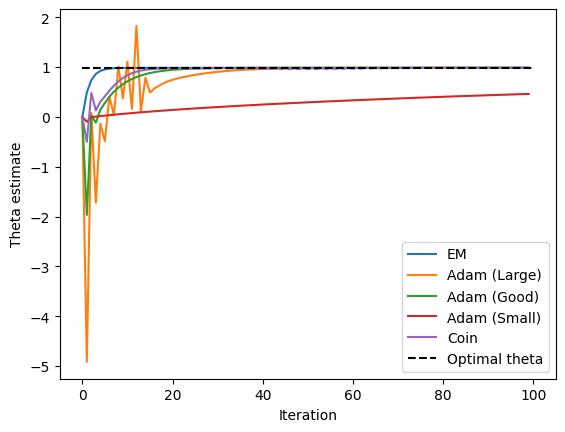

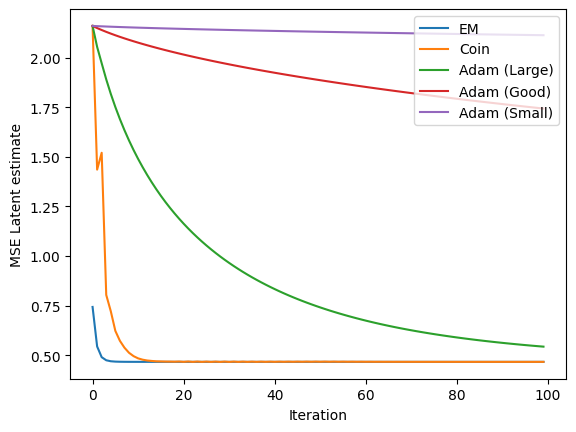

In [45]:
# # Run Adam-SVGD using theree different step-sizes:
large = 5.0
good = 2.0
small = 1e-1

x_ada_large, th_ada_large = ada_svgd(model, data, X0, th0, K, theta_step_size = large, latent_step_size= large)  # Large step-size
x_ada_good, th_ada_good = ada_svgd(model, data, X0, th0, K, theta_step_size = good, latent_step_size= good)  # Good step-size
x_ada_small, th_ada_small = ada_svgd(model, data, X0, th0, K, theta_step_size = small, latent_step_size= small)  # Small step-size


# Plot parameter estimates as a function of step number k:
plt.plot(th_em, label='EM')
plt.plot(th_ada_large, label='Adam (Large)')
plt.plot(th_ada_good, label='Adam (Good)')
plt.plot(th_ada_small, label='Adam (Small)')
plt.plot(th_coin, label='Coin')
plt.hlines(y.mean(), 0, K, label='Optimal theta', linestyles='dashed', color='black')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.ylabel("Theta estimate")
plt.show()

plt.plot(((x_mean_em - latent) ** 2).mean(axis=1), label='EM')
plt.plot(((x_coin.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin')
plt.plot(((x_adam_large.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Adam (Large)')
plt.plot(((x_adam_good.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Adam (Good)')
plt.plot(((x_adam_small.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Adam (Small)')
plt.xlabel('Iteration')
plt.ylabel("MSE Latent estimate")
plt.legend(loc='upper right')
plt.show()

### Soul vs Coin

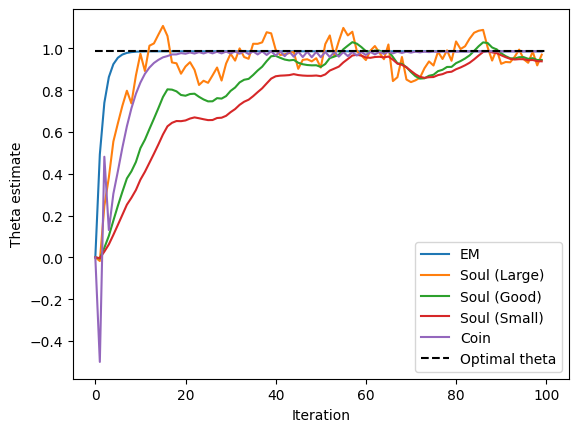

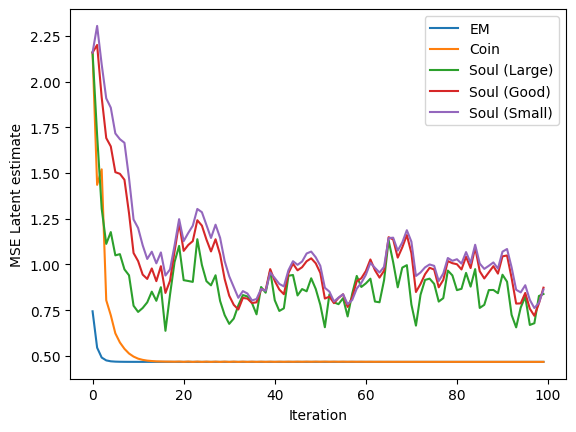

In [46]:
# Plot parameter estimates as a function of step number k:
plt.plot(th_em, label='EM')
plt.plot(th_soul_large, label='Soul (Large)')
plt.plot(th_soul_good, label='Soul (Good)')
plt.plot(th_soul_small, label='Soul (Small)')
plt.plot(th_coin, label='Coin')
plt.hlines(y.mean(), 0, K, label='Optimal theta', linestyles='dashed', color='black')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.ylabel("Theta estimate")
plt.show()

plt.plot(((x_mean_em - latent) ** 2).mean(axis=1), label='EM')
plt.plot(((x_coin.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin')
plt.plot(((x_soul_large.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Soul (Large)')
plt.plot(((x_soul_good.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Soul (Good)')
plt.plot(((x_soul_small.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Soul (Small)')
plt.xlabel('Iteration')
plt.ylabel("MSE Latent estimate")
plt.legend(loc='upper right')
plt.show()

# Experiment 2 (Bias investigation)

We now consider a single latent dimension. For which, the optimal posterior variance can be shown to be 1/2.

It seems coin tends to underestimate the variance, for smaller numbers of particles.

In [47]:
key = jr.PRNGKey(123)
K = 20000  # Number of steps.

Ny = 1
Dy = 1
key = jr.PRNGKey(42)
theta = jnp.array([1.0])

key_y, key_latent = jr.split(key)
latent = theta + jr.normal(key_latent, (1, Dy))
y = jr.normal(key_y, (Ny, Dy)) + latent

data = Dataset(y=y)


for N in [1, 5, 20, 100]:

    th0 = jnp.array([1.0])  # Initial parameter guess.
    X0 = jr.normal(key, (N, Dy))  # Initial particle cloud.

    model = HierarchicalModel()

    # Run coin_svgd:
    x_coin, th_coin = coin_svgd(model, data, X0, th0, K) 

    mu1 = x_coin.mean(axis=1)
    mu2 = (x_coin ** 2).mean(axis=1)
    var = (jnp.cumsum(mu2)/jnp.arange(1, K + 1) 
            - (jnp.cumsum(mu1)/jnp.arange(1, K + 1)) ** 2)

    plt.plot(var , label='Coin (N = {})'.format(N))

plt.hlines(0.5, 0, K, label='Optimal variance', linestyles='dashed', color='black')
plt.legend(loc='upper right')

But it achieves better convergence than PGD

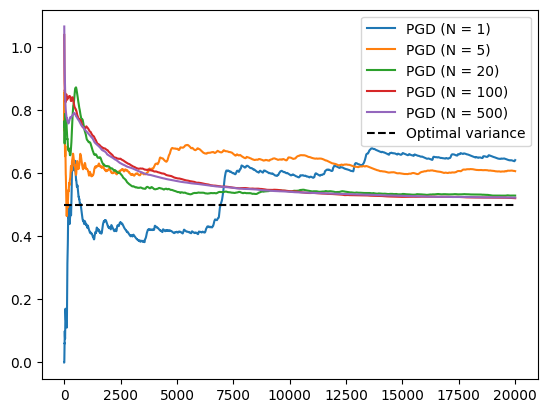

In [ ]:
for N in [1, 5, 20, 100, 500]:

    th0 = jnp.array([1.0])  # Initial parameter guess.
    X0 = jr.normal(key, (N, Dy))  # Initial particle cloud.

    model = HierarchicalModel()

    # Run coin_svgd:
    x_pgd, th_pgd = pgd(model, data, X0, th0, K)

    mu1 = x_pgd.mean(axis=1)
    mu2 = (x_pgd ** 2).mean(axis=1)
    var = (jnp.cumsum(mu2)/jnp.arange(1, K + 1) 
            - (jnp.cumsum(mu1)/jnp.arange(1, K + 1)) ** 2)

    plt.plot(var , label='PGD (N = {})'.format(N))

plt.hlines(0.5, 0, K, label='Optimal variance', linestyles='dashed', color='black')
plt.legend(loc='upper right')